# Trajectory inference for hematopoiesis in mouse

Reconstructing myeloid and erythroid differentiation for data of [Paul et al. (2015)](http://doi.org/10.1016/j.cell.2015.11.013).

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as pl
from matplotlib import rcParams
import scanpy as sc

In [3]:
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
results_file = './write/paul15.h5ad'
sc.settings.set_figure_params(dpi=80, frameon=False, figsize=(3, 3), facecolor='white')  # low dpi (dots per inch) yields small inline figures

-----
anndata     0.9.1
scanpy      1.9.3
-----
PIL                 9.5.0
asttokens           NA
backcall            0.2.0
colorama            0.4.6
comm                0.1.3
cycler              0.10.0
cython_runtime      NA
dateutil            2.8.2
debugpy             1.6.7
decorator           5.1.1
executing           1.2.0
h5py                3.8.0
igraph              0.10.4
ipykernel           6.23.1
jedi                0.18.2
joblib              1.2.0
kiwisolver          1.4.4
leidenalg           0.9.1
llvmlite            0.40.0
louvain             0.8.0
matplotlib          3.7.1
mpl_toolkits        NA
natsort             8.3.1
numba               0.57.0
numpy               1.24.3
packaging           23.1
pandas              2.0.1
parso               0.8.3
pexpect             4.8.0
pickleshare         0.7.5
pkg_resources       NA
platformdirs        3.5.1
prompt_toolkit      3.0.38
psutil              5.9.5
ptyprocess          0.7.0
pure_eval           0.2.2
pydev_ipython       N

In [4]:
adata = sc.datasets.paul15()

/home/asus/miniconda3/envs/ipy/lib/python3.11/site-packages/scanpy/datasets/_datasets.py:202: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns['iroot'] = 840


In [5]:
adata

AnnData object with n_obs × n_vars = 2730 × 3451
    obs: 'paul15_clusters'
    uns: 'iroot'

Let us work with a higher precision than the default 'float32' to ensure _exactly_ the same results across different computational platforms.

In [6]:
adata.X = adata.X.astype('float64')  # this is not required and results will be comparable without it

## Preprocessing and Visualization

Apply a simple [preprocessing recipe](https://scanpy.readthedocs.io/en/latest/api/scanpy.api.pp.recipe_zheng17.html).

In [7]:
sc.pp.recipe_zheng17(adata)

running recipe zheng17
normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)
    finished (0:00:00)


In [8]:
adata

AnnData object with n_obs × n_vars = 2730 × 1000
    obs: 'paul15_clusters', 'n_counts_all'
    var: 'n_counts', 'mean', 'std'
    uns: 'iroot', 'log1p'

In [9]:
sc.pl.pca(adata)

KeyError: "Could not find 'pca' or 'X_pca' in .obsm"

In [7]:
sc.tl.pca(adata, svd_solver='arpack')

computing PCA
    with n_comps=50
    finished (0:00:00)


In [26]:
adata

AnnData object with n_obs × n_vars = 2730 × 1000
    obs: 'paul15_clusters', 'n_counts_all', 'louvain', 'louvain_anno'
    var: 'n_counts', 'mean', 'std'
    uns: 'iroot', 'log1p', 'pca', 'neighbors', 'draw_graph', 'paul15_clusters_colors', 'diffmap_evals', 'louvain', 'paga', 'louvain_sizes', 'louvain_colors'
    obsm: 'X_pca', 'X_draw_graph_fr', 'X_diffmap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [8]:
sc.pp.neighbors(adata, n_neighbors=4, n_pcs=20)
sc.tl.draw_graph(adata)

computing neighbors
    using 'X_pca' with n_pcs = 20


/home/asus/miniconda3/envs/ipy/lib/python3.11/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/asus/miniconda3/envs/ipy/lib/python3.11/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/asus/miniconda3/envs/ipy/lib/python3.11/site-packages/umap/distances.py:

    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:03)
drawing single-cell graph using layout 'fa'
    finished: added
    'X_draw_graph_fr', graph_drawing coordinates (adata.obsm) (0:00:04)


/home/asus/miniconda3/envs/ipy/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


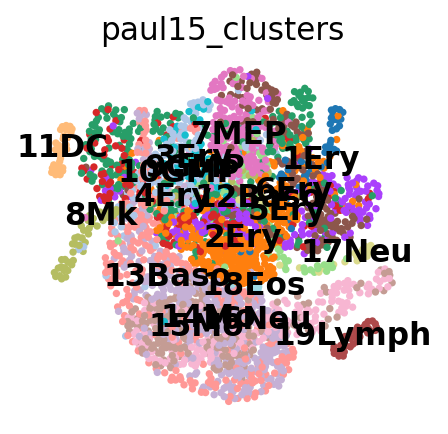

In [21]:
sc.pl.draw_graph(adata, color='paul15_clusters', legend_loc='on data')

This looks pretty messy.

## Optional: Denoising the graph

To denoise the graph, we represent it in diffusion map space (and not in PCA space). Computing distances within a few diffusion components amounts to denoising the graph - we just take a few of the first spectral components. It's very similar to denoising a data matrix using PCA. The approach has been used in a couple of papers, see e.g. [Schiebinger et al. (2017)](https://doi.org/10.1101/191056) or [Tabaka et al. (2018)](https://doi.org/10.1101/512582). It's also related to the principles behind MAGIC [Dijk et al. (2018)](https://doi.org/10.1016/j.cell.2018.05.061).

:::{note}
This is *not* a necessary step, neither for PAGA, nor clustering, nor pseudotime estimation. You might just as well go ahead with a non-denoised graph. In many situations (also here), this will give you very decent results.
:::

In [10]:
sc.tl.diffmap(adata)
sc.pp.neighbors(adata, n_neighbors=10, use_rep='X_diffmap')

computing Diffusion Maps using n_comps=15(=n_dcs)
computing transitions
    finished (0:00:00)
    eigenvalues of transition matrix
    [1.         1.         0.9989278  0.99671    0.99430376 0.98939794
     0.9883687  0.98731077 0.98398703 0.983007   0.9790806  0.9762548
     0.9744365  0.9729161  0.9652972 ]
    finished: added
    'X_diffmap', diffmap coordinates (adata.obsm)
    'diffmap_evals', eigenvalues of transition matrix (adata.uns) (0:00:00)
computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)


In [11]:
sc.tl.draw_graph(adata)

drawing single-cell graph using layout 'fa'
    finished: added
    'X_draw_graph_fr', graph_drawing coordinates (adata.obsm) (0:00:04)


/home/asus/miniconda3/envs/ipy/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(


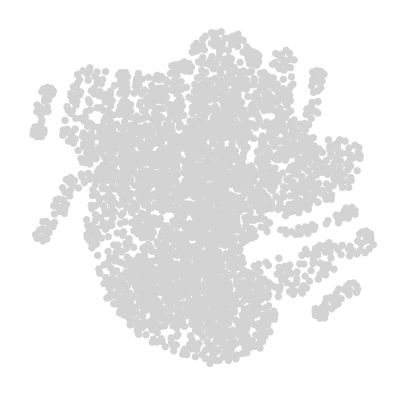

In [24]:
sc.pl.draw_graph(adata, color='paul15_clusters')

/home/asus/miniconda3/envs/ipy/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


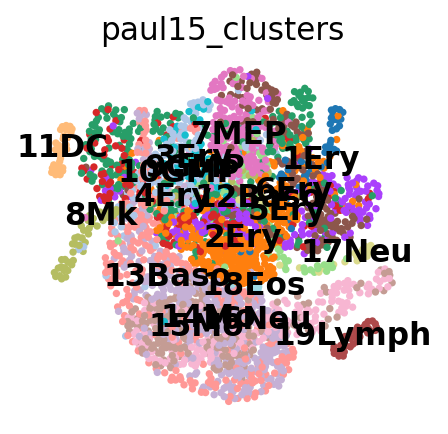

In [12]:
sc.pl.draw_graph(adata, color='paul15_clusters', legend_loc='on data')

This still looks messy, but in a different way: a lot of the branches are overplotted.

## Clustering and PAGA

:::{note}
Note that today, we'd use `sc.tl.leiden` - here, we use `sc.tl.louvain` the sake of reproducing the paper results.
:::

In [22]:
sc.tl.louvain(adata, resolution=1.0)

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 25 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)


Annotate the clusters using marker genes.

| cell type | marker |
| --- | --- |
|HSCs | Procr |
|Erythroids | Gata1, Klf1, Epor, Gypa, Hba-a2, Hba-a1, Spi1 |
|Neutrophils | Elane, Cebpe, Ctsg, Mpo, Gfi1 |
|Monocytes | Irf8, Csf1r, Ctsg, Mpo |
|Megakaryocytes | Itga2b (encodes protein CD41), Pbx1, Sdpr, Vwf |
|Basophils | Mcpt8, Prss34 |
|B cells | Cd19, Vpreb2, Cd79a |
|Mast cells| Cma1, Gzmb, CD117/C-Kit |
|Mast cells & Basophils| Ms4a2, Fcer1a, Cpa3, CD203c (human)|

For simple, coarse-grained visualization, compute the PAGA graph, a coarse-grained and simplified (abstracted) graph. Non-significant edges in the coarse- grained graph are thresholded away.

In [15]:
sc.tl.paga(adata, groups='louvain')

running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:00)


--> added 'pos', the PAGA positions (adata.uns['paga'])


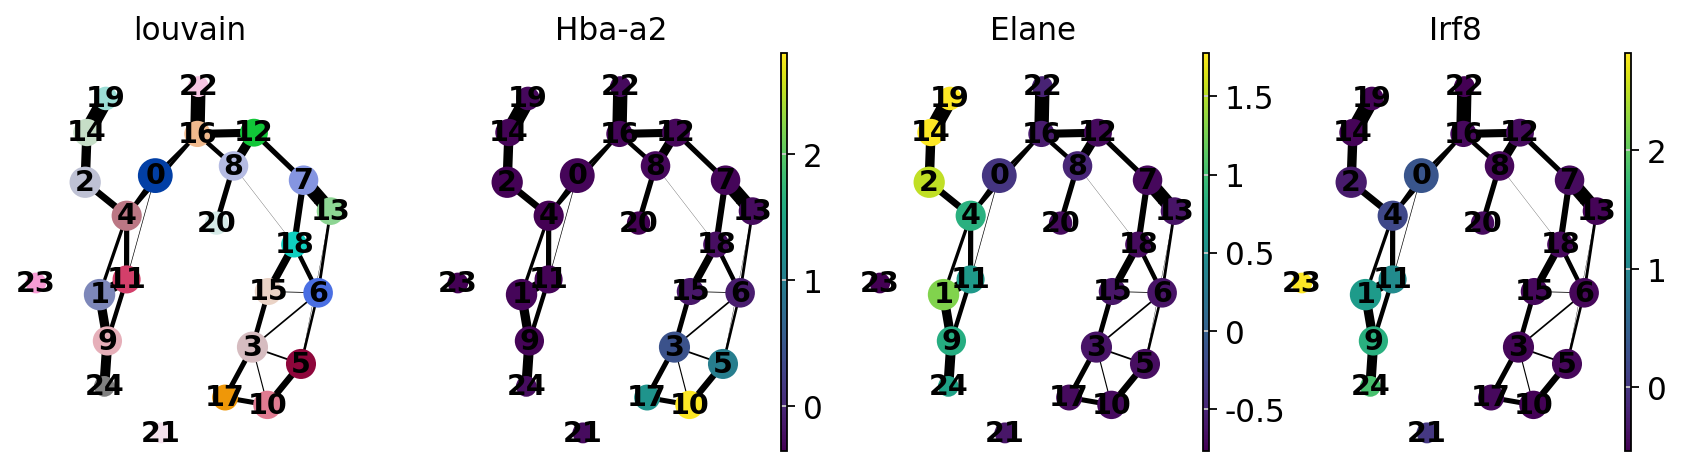

In [16]:
sc.pl.paga(adata, color=['louvain', 'Hba-a2', 'Elane', 'Irf8'])

--> added 'pos', the PAGA positions (adata.uns['paga'])


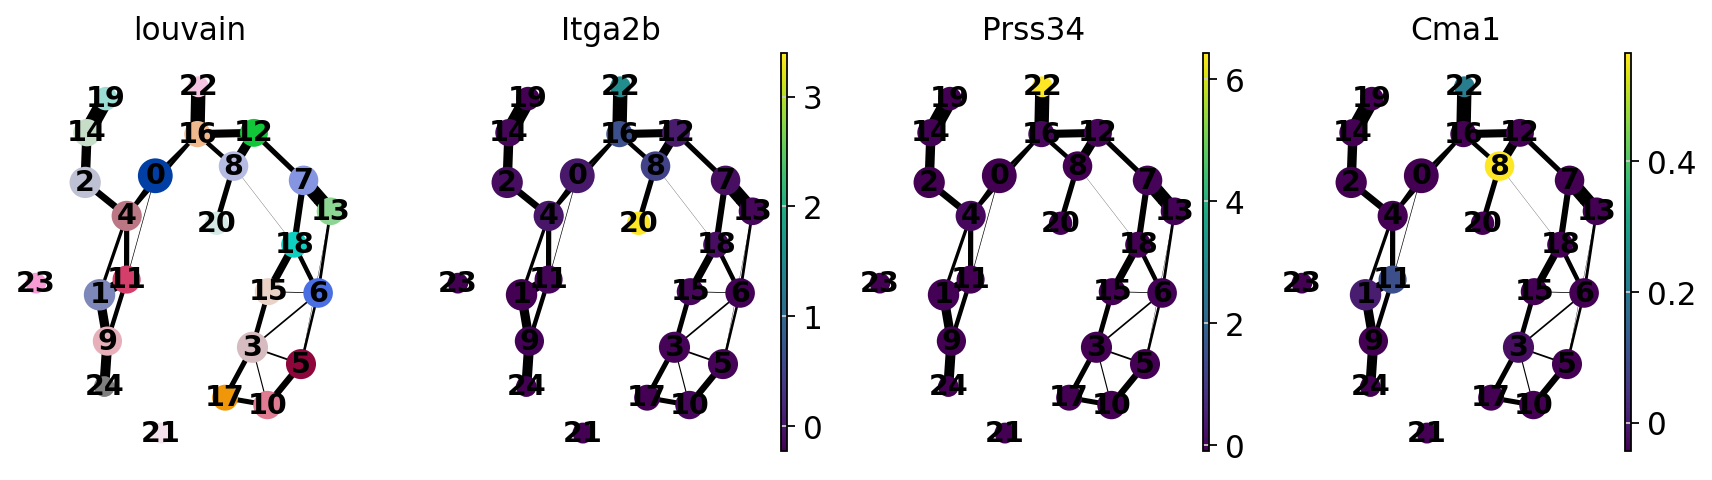

In [17]:
sc.pl.paga(adata, color=['louvain', 'Itga2b', 'Prss34', 'Cma1'])

Actually annotate the clusters --- note that *Cma1* is a Mast cell marker and only appears in a small fraction of the cells in the progenitor/stem cell cluster 8, see the single-cell resolved plot below.

In [18]:
adata.obs['louvain'].cat.categories

Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24'],
      dtype='object')

In [19]:
adata.obs['louvain_anno'] = adata.obs['louvain']

In [20]:
adata.obs['louvain_anno'].cat.categories = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10/Ery', '11', '12',
       '13', '14', '15', '16/Stem', '17', '18', '19/Neu', '20/Mk', '21', '22/Baso', '23', '24/Mo']

AttributeError: property 'categories' of 'Categorical' object has no setter

Let's use the annotated clusters for PAGA.

In [ ]:
sc.tl.paga(adata, groups='louvain_anno')

In [ ]:
sc.pl.paga(adata, threshold=0.03, show=False)

## Recomputing the embedding using PAGA-initialization

The following is just as well possible for a UMAP.

In [ ]:
sc.tl.draw_graph(adata, init_pos='paga')

Now we can see all marker genes also at single-cell resolution in a meaningful layout.

In [ ]:
sc.pl.draw_graph(adata, color=['louvain_anno', 'Itga2b', 'Prss34', 'Cma1'], legend_loc='on data')

Choose the colors of the clusters a bit more consistently.

In [ ]:
pl.figure(figsize=(8, 2))
for i in range(28):
    pl.scatter(i, 1, c=sc.pl.palettes.zeileis_28[i], s=200)
pl.show()

In [ ]:
zeileis_colors = np.array(sc.pl.palettes.zeileis_28)
new_colors = np.array(adata.uns['louvain_anno_colors'])

In [ ]:
new_colors[[16]] = zeileis_colors[[12]]  # Stem colors / green
new_colors[[10, 17, 5, 3, 15, 6, 18, 13, 7, 12]] = zeileis_colors[[5, 5, 5, 5, 11, 11, 10, 9, 21, 21]]  # Ery colors / red
new_colors[[20, 8]] = zeileis_colors[[17, 16]]  # Mk early Ery colors / yellow
new_colors[[4, 0]] = zeileis_colors[[2, 8]]  # lymph progenitors / grey
new_colors[[22]] = zeileis_colors[[18]]  # Baso / turquoise
new_colors[[19, 14, 2]] = zeileis_colors[[6, 6, 6]]  # Neu / light blue
new_colors[[24, 9, 1, 11]] = zeileis_colors[[0, 0, 0, 0]]  # Mo / dark blue
new_colors[[21, 23]] = zeileis_colors[[25, 25]]  # outliers / grey

In [ ]:
adata.uns['louvain_anno_colors'] = new_colors

And add some white space to some cluster names. The layout shown here differs from the one in the paper, which can be found [here](https://github.com/theislab/paga/blob/f53fcdf4a861b7d3410f8096ffc13a07f1d225c0/blood/paul15/paul15.ipynb). These differences, however, are only cosmetic. We had to change the layout as we moved from a randomized PCA and float32 to float64 precision.

In [ ]:
sc.pl.paga_compare(
    adata, threshold=0.03, title='', right_margin=0.2, size=10, edge_width_scale=0.5,
    legend_fontsize=12, fontsize=12, frameon=False, edges=True, save=True)

## Reconstructing gene changes along PAGA paths for a given set of genes

Choose a root cell for diffusion pseudotime.

In [ ]:
adata.uns['iroot'] = np.flatnonzero(adata.obs['louvain_anno']  == '16/Stem')[0]

In [ ]:
sc.tl.dpt(adata)

Select some of the marker gene names.

In [ ]:
gene_names = ['Gata2', 'Gata1', 'Klf1', 'Epor', 'Hba-a2',  # erythroid
              'Elane', 'Cebpe', 'Gfi1',                    # neutrophil
              'Irf8', 'Csf1r', 'Ctsg']                     # monocyte

Use the full raw data for visualization.

In [ ]:
adata_raw = sc.datasets.paul15()
sc.pp.log1p(adata_raw)
sc.pp.scale(adata_raw)
adata.raw = adata_raw

In [ ]:
sc.pl.draw_graph(adata, color=['louvain_anno', 'dpt_pseudotime'], legend_loc='on data')

In [ ]:
paths = [('erythrocytes', [16, 12, 7, 13, 18, 6, 5, 10]),
         ('neutrophils', [16, 0, 4, 2, 14, 19]),
         ('monocytes', [16, 0, 4, 11, 1, 9, 24])]

In [ ]:
adata.obs['distance'] = adata.obs['dpt_pseudotime']

In [ ]:
adata.obs['clusters'] = adata.obs['louvain_anno']  # just a cosmetic change

In [ ]:
adata.uns['clusters_colors'] = adata.uns['louvain_anno_colors']

In [ ]:
!mkdir write

In [ ]:
_, axs = pl.subplots(ncols=3, figsize=(6, 2.5), gridspec_kw={'wspace': 0.05, 'left': 0.12})
pl.subplots_adjust(left=0.05, right=0.98, top=0.82, bottom=0.2)
for ipath, (descr, path) in enumerate(paths):
    _, data = sc.pl.paga_path(
        adata, path, gene_names,                         
        show_node_names=False,
        ax=axs[ipath],
        ytick_fontsize=12,
        left_margin=0.15,
        n_avg=50,
        annotations=['distance'],
        show_yticks=True if ipath==0 else False,
        show_colorbar=False,
        color_map='Greys',
        groups_key='clusters',
        color_maps_annotations={'distance': 'viridis'},
        title='{} path'.format(descr),
        return_data=True,
        show=False)
    data.to_csv('./write/paga_path_{}.csv'.format(descr))
pl.savefig('./figures/paga_path_paul15.pdf')
pl.show()